# Pump It Up Data Mining the Water Table

# Content:
1. [Introduction](#first-bullet)
2. [Data Overview](#second-bullet)
    * [Loading Datasets](#third-bullet)
    * [Changing Data Type](#fourth-bullet)
    * [Data Exploration](#fifth-bullet)
        * [Dataset Profile](#sixth-bullet)
* [Data Cleaning]
    * [Handeling Outliers]
    * [Handeling Missing Values]
    * [Checking Correlations]
    * [Removing Irrelevant Variables]
    * [Data Transfomations]
* [Feature Engineering]
    * [PCA]
* [Modeling]
    * [LDA]
    * [Baseline Model]

* `[The Pipeline](#fifth-bullet)


## 1. Introduction <a class="anchor" id="first-bullet"></a>

## 2. Data Overview

   ### 2.1. Loading Datasets <a class="anchor" id="third-bullet"></a>

In [4]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


In [5]:
training_label = pd.read_csv("data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
training_values = pd.read_csv("data/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
test = pd.read_csv("data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")

train = training_values.merge(training_label, on = 'id')


test['status_group'] = '*unknown*'#the unknown target variable

#We will annotate our train and test set before combining them for simple indexing later on. 
train['data_set'] = 'train'
test['data_set'] = 'test'

trainset = pd.DataFrame(train)
testset = pd.DataFrame(test)

display(Markdown("There are {} observations in training set, and {} observations in the test set:{} in total".format(len(train), len(test), len(train) + len(test))))
display(Markdown("There are {} variables in training dataset including the target variable.".format(len(train.columns))))

There are 59400 observations in training set, and 14850 observations in the test set:74250 in total

There are 42 variables in training dataset including the target variable.

In [6]:
display(Markdown("Combining test and train set.")) 
dataset = trainset.append(testset)
dataset.head()

Combining test and train set.

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,train
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,train
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,train
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,train


In [7]:
dataset[:59400].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

### 2.2. Data Type <a class="anchor" id="fourth-bullet"></a>

The data loaded recognized numeric and object variable in our dataset. We need to change these to categories and also change other variables which are defined as numbers into categories. 

In [6]:
#Changing datatypes from Objects to Categories.
for col in dataset:
    if dataset.dtypes[col].name == 'object':
        dataset[col] = dataset[col].astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null category
funder                   69746 non-null category
gps_height               74250 non-null int64
installer                69718 non-null category
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null category
num_private              74250 non-null int64
basin                    74250 non-null category
subvillage               73780 non-null category
region                   74250 non-null category
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null category
ward                     74250 non-null category
population               74250 non-null int64
public_meeting           70095

In [7]:
#Setting other varaibles defined as numbers to categories. 
other_categoricals = ['id', 'district_code', 'construction_year', 'region_code',
                      'gps_height', 'longitude', 'latitude']
dataset[other_categoricals] = dataset[other_categoricals].astype('category')

### 2.3. Data Exploration <a class="anchor" id="fifth-bullet"></a>

##### Dataset Profile <a class="anchor" id="sixth-bullet"></a>

In [24]:
profile=ProfileReport(dataset[:59400], title='Training Dataset Profiling Report',html={'style':{'full_width':True}})

In [25]:
profile.to_widgets()

The profile of training set in our dataset highlights key aspects of our data, including correlations, missing values, and distribution. We will further explore the variables one by one below. 

#### Status Group

In [8]:
dataset["status_group"].value_counts()

functional                 32259
non functional             22824
*unknown*                  14850
functional needs repair     4317
Name: status_group, dtype: int64

The classes in our train set is unbalanced as we have very small proportion for 'Functional Needs Repair'. We will try upsample and undersample method later on to fix this issue.

#### Check Null Values

In [100]:
trainset.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Text(0.5, 0.98, '')

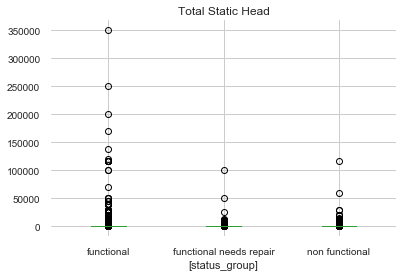

In [23]:
axes = dataset[:59400].boxplot(column=['amount_tsh'],by=['status_group']).set_title('Total Static Head')
fig = axes.get_figure()
fig.suptitle('')


We have 7 variables ('funder', 'installer', 'subvillage','public_meeting', 'public_meeting', 'scheme_management', 'scheme_name', 'permit') with missing values. 
However, the dataset profile shows there are variables below that have zeros:
    - "amount_sth"
    - "population"
    - "gps_height"
    - "construction_year"
We will replace these values to missing values to impute them later. 

#### Duplicates

We have no duplicated rows in our dataset.

In [113]:
dataset[dataset["id"].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,data_set


#### Checking Data Distribution

In [14]:
dataset[:59400].describe()

,amount_tsh,num_private,population
count,59400.000000,59400.000000,59400.000000
mean,317.650385,0.474141,179.909983
std,2997.574558,12.236230,471.482176
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,25.000000
75%,20.000000,0.000000,215.000000
max,350000.000000,1776.000000,30500.000000


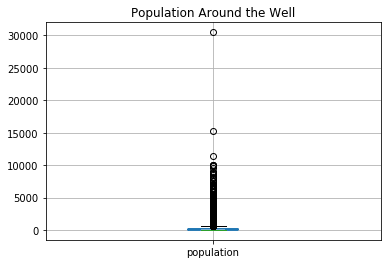

In [125]:
boxplot1 = dataset[:59400].boxplot(column=['population'],notch=True).set_title('Population Around the Well')

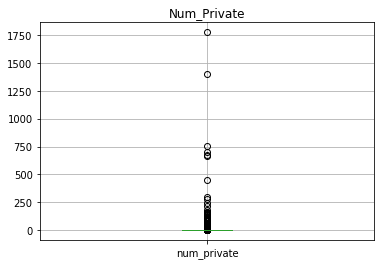

In [123]:
boxplot2 = dataset[:59400].boxplot(column=['num_private']).set_title('Num_Private')

There are alot of '0' values for amount of static head for working pumps which is an error. We will change this values to NaN and impute them as missing values instead, only for the 'functional' and 'functional needs repair', as it is possible the non-functional the pump isn't working due to this reason. 

There is no clear definition of what num_private means and 99% of the observations are zero thus we can ignore it from our model.

### 3.1. Outliers

We only have three variable which are numerical and we will check if we have any outliers among them. 

### 2.4. Missing Values

In [22]:
trainset.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

We have 7 variables ('funder', 'installer', 'subvillage','public_meeting', 'public_meeting', 'scheme_management', 'scheme_name', 'permit') with missing values. 